# Agglomerative Hierarchical Clustering

## Importing the libraries

In [18]:
import os
import requests
import gzip
import shutil
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.spatial import distance_matrix as distanceMatrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn import svm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import seaborn as sns

## Functions to load and preprocess the data

In [2]:
def loadData(path):
    data = pd.read_csv(path)
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return x, y

def splitData(x, y, train_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0, stratify=y)
    return x_train, x_test, y_train, y_test

def preprocessData(x):
    
    ct = ColumnTransformer( [('one_hot_encoder', OneHotEncoder(), [1, 2, 3])], remainder='passthrough' )
    ct = ct.fit(x)
    x = pd.DataFrame(ct.transform(x))

    # Scaling the data since the features are in different scales
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    x = pd.DataFrame(scaler.transform(x))

    return x

## The Algorithm

In [3]:
def constructDistanceMatrix(data):
    distance_matrix = distanceMatrix(data, data)
    distance_matrix = (distance_matrix + distance_matrix.T)/2
    np.fill_diagonal(distance_matrix, 0)
    return distance_matrix

def linkage(distance_matrix, clusters, cluster1, cluster2, linkage):
    if linkage == 'single': # Minimum distance between two clusters
        min_distance = np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] < min_distance:
                    min_distance = distance_matrix[i,j]
        return min_distance
    elif linkage == 'complete': # Maximum distance between two clusters
        max_distance = -np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] > max_distance:
                    max_distance = distance_matrix[i,j]
        return max_distance
    elif linkage == 'average' or linkage == 'mean': # Average distance between two clusters
        sum_distance = 0
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                sum_distance += distance_matrix[i,j]
        return sum_distance/(len(clusters[cluster2]) * len(clusters[cluster1]))
    else:
        raise ValueError('Invalid linkage type')
    
def hierarchical_clustering(data, linkage_type, n_clusters, y):
    # Marking each data point as a cluster
    clusters = [[i] for i in range(len(data))]

    # Calculating the distance matrix using Euclidean distance (default of distanceMatrix function)
    distance_matrix = constructDistanceMatrix(data)
    
    # Iteratively merging the clusters
    while len(clusters) > n_clusters:

        # Finding closest two clusters
        min_distance = np.inf
        min_i,min_j = -1,-1
        for i in range(len(clusters)):
            for j in range(i+1,len(clusters)):
                dist = distance_matrix[i,j]
                if dist < min_distance:
                    min_distance = dist
                    min_i,min_j = i,j

        # Merging the closest two clusters
        clusters[min_i] = clusters[min_i] + clusters[min_j]

        # Removing the second cluster
        clusters.pop(min_j)
        
        # Adjusting the distance matrix 
        for i in range(len(clusters)):
            if i == min_i: continue
            distance_matrix[min_i,i] = distance_matrix[i,min_i] = linkage(distance_matrix, clusters, i, min_i, linkage_type)
    
    # Using the majority voting to get the cluster labels 
    indexToLabel = {}
    for i in range(len(clusters)):
        labels = []
        for j in clusters[i]:
            labels.append(y[j])
        indexToLabel[i] = max(set(labels), key=labels.count)
        

    predicted = []
    for i in range(len(data)):
        for j in range(len(clusters)):
            if i in clusters[j]:
                predicted.append(indexToLabel[j])
                break
    return clusters, predicted


## Loading the Raw Data

In [4]:
# Loading the data
x, y = loadData('kddcup.data_10_percent.csv')

## Preprocessing the Data

In [5]:
# Preprocessing the data
x = preprocessData(x)
print("The shape of the training data is: ", x.shape)

The shape of the training data is:  (494020, 118)


## Splitting the Data into Training and Test Sets

In [6]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = splitData(x, y, train_size=0.00025)

## Saving the Data

In [7]:
# Save the x_train and y_train as numpy arrays
np.save('hierarchicalClustering-Preprocessed/x_train.npy', x_train)
np.save('hierarchicalClustering-Preprocessed/y_train.npy', y_train)

#### Loading the Preprocessed Data

In [8]:
# Loading the preprocessed data as numpy arrays
x_train = np.load('hierarchicalClustering-Preprocessed/x_train.npy', allow_pickle=True)
y_train = np.load('hierarchicalClustering-Preprocessed/y_train.npy', allow_pickle=True)

In [9]:
''''# Loading the preprocessed data as numpy arrays
x_train = np.load('Clustering_data-preprocessed/x_train.npy', allow_pickle=True)
y_train = np.load('Clustering_data-preprocessed/y_train.npy', allow_pickle=True)'''

"'# Loading the preprocessed data as numpy arrays\nx_train = np.load('Clustering_data-preprocessed/x_train.npy', allow_pickle=True)\ny_train = np.load('Clustering_data-preprocessed/y_train.npy', allow_pickle=True)"

## Evaluation

In [10]:
# Applying hierarchical clustering
clusters, y_pred = hierarchical_clustering(x_train, 'complete', 512, y_train)

# Evaluating the model
print("Macro: ")
print("Precision: ", precision_score(y_train, y_pred, average='macro'))
print("Recall: ", recall_score(y_train, y_pred, average='macro'))
print("F1 score: ", f1_score(y_train, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print("Weighted: ")
print("Precision: ", precision_score(y_train, y_pred, average='weighted'))
print("Recall: ", recall_score(y_train, y_pred, average='weighted'))
print("F1 score: ", f1_score(y_train, y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print(classification_report(y_train, y_pred))

# Now, let's measure the conditional entropy
totalEntropy = 0
for i in range(len(clusters)):
    clusterEntropy = 0
    counterLabels = {}
    for j in clusters[i]:
        counterLabels[y_train[j]] = counterLabels.get(y_train[j], 0) + 1
    for label in counterLabels:
        clusterEntropy += counterLabels[label]/len(clusters[i]) * np.log2(counterLabels[label]/len(clusters[i]))
    totalEntropy += -clusterEntropy * len(clusters[i])/len(y_train)

print("The average conditional entropy is: ", totalEntropy)

Macro: 
Precision:  1.0
Recall:  1.0
F1 score:  1.0
Accuracy:  1.0
--------------------------------------------------
Weighted: 
Precision:  1.0
Recall:  1.0
F1 score:  1.0
Accuracy:  1.0
--------------------------------------------------
              precision    recall  f1-score   support

       back.       1.00      1.00      1.00         1
    neptune.       1.00      1.00      1.00        27
     normal.       1.00      1.00      1.00        24
      satan.       1.00      1.00      1.00         1
      smurf.       1.00      1.00      1.00        70

    accuracy                           1.00       123
   macro avg       1.00      1.00      1.00       123
weighted avg       1.00      1.00      1.00       123

The average conditional entropy is:  0.0


## Confusion Matrix

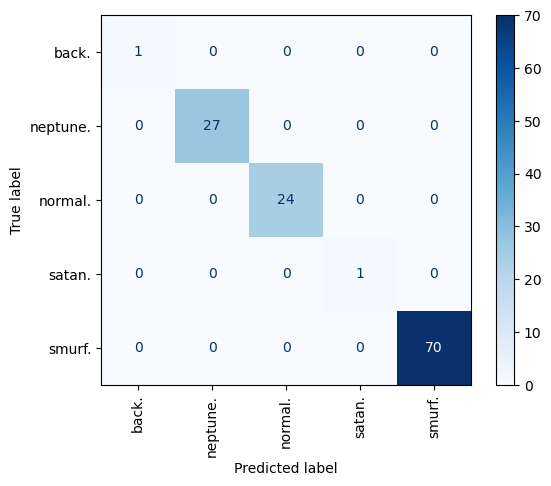

In [11]:
# Printing the confusion matrix
cm = confusion_matrix(y_train, y_pred)
# Displaying the confusion matrix in much bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.show()

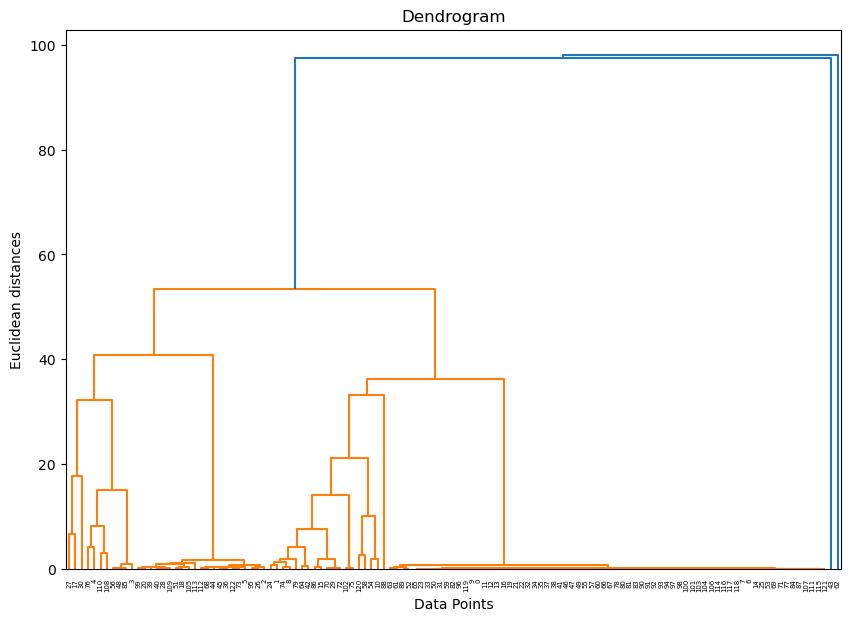

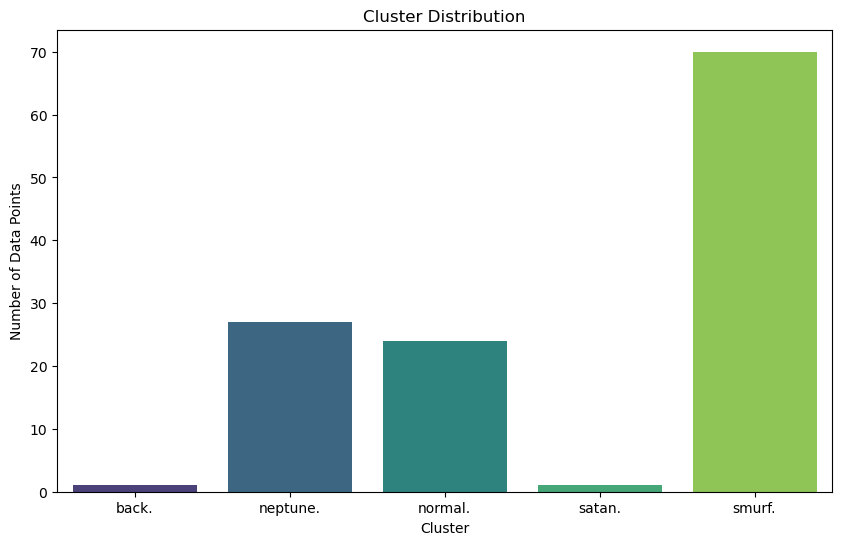

In [12]:

## Additional Visualizations

# Plotting the dendrogram
from scipy.cluster.hierarchy import dendrogram, linkage

# Using 'ward' linkage for dendrogram visualization
linked = linkage(x_train, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Euclidean distances')
plt.show()

# Plotting the cluster distribution
unique, counts = np.unique(y_pred, return_counts=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=unique, y=counts, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Number of Data Points')
plt.show()

## SVM Anomaly Detection based on Dendrogram Clusters


In [13]:
# Generate the linkage matrix for anomaly detection
Z = linkage(x_train, method='ward')

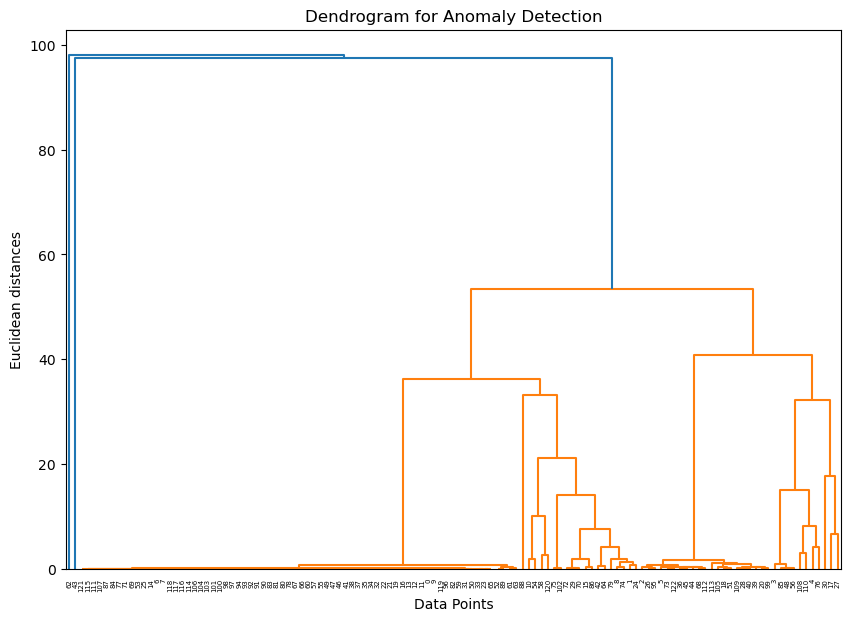

In [14]:
# Plot the dendrogram to decide the threshold
plt.figure(figsize=(10, 7))
dendrogram(Z)
plt.title('Dendrogram for Anomaly Detection')
plt.xlabel('Data Points')
plt.ylabel('Euclidean distances')
plt.show()

In [28]:
# Choose a threshold to cut the dendrogram
threshold = 50  # Adjust this threshold based on the dendrogram
clusters = fcluster(Z, threshold, criterion='distance')

In [29]:
# Determine which clusters are normal and which are anomalies
# For simplicity, let's assume cluster 1 is normal and others are anomalies
normal_clusters = [1]
labels = np.where(np.isin(clusters, normal_clusters), 1, -1)

In [30]:
# Normalize the data
scaler = StandardScaler()
data_normalized = scaler.fit_transform(x_train)
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'nu': [0.01, 0.05, 0.1, 0.2],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

In [33]:
# Train a one-class SVM on the normal data points
# Initialize the OneClassSVM model
oc_svm = svm.OneClassSVM(kernel="rbf")
from sklearn.model_selection import GridSearchCV
import joblib


# Perform grid search with cross-validation
grid_search = GridSearchCV(oc_svm, param_grid, cv=5, scoring='accuracy')
grid_search.fit(data_normalized[labels == 1])

# Get the best model
best_oc_svm = grid_search.best_estimator_


C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:821: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\HP\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 808, in _score
    scores = scorer(estimator, X_test)
TypeError: __call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
C:\Users\HP\anaconda3\lib\site-packages\sklearn\mo

In [36]:
true_labels = np.where(labels == 1, 1, -1)  # True labels (1 for normal, -1 for anomalies)
predicted_labels = y_pred_svm  # Predicted labels from SVM
# Predict anomalies
y_pred_svm = best_oc_svm.predict(data_normalized)


In [37]:

# Results
anomalies = data_normalized[y_pred_svm == -1]
anomalies_count = len(anomalies)
print(f"Detected {anomalies_count} anomalies with SVM")


Detected 42 anomalies with SVM


Accuracy: 0.93
Precision: 1.00
Recall: 0.91
F1 Score: 0.95


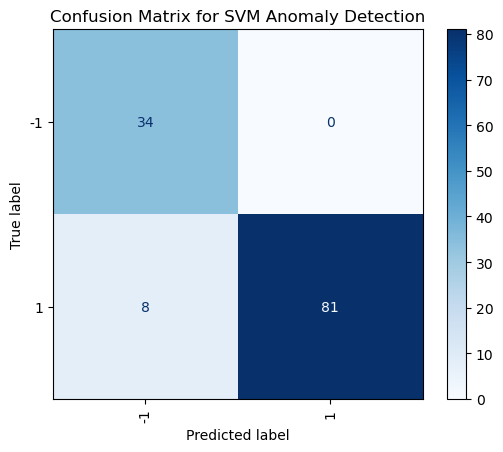

In [39]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Assume true_labels and predicted_labels are defined as per your previous setup
true_labels = np.where(labels == 1, 1, -1)  # True labels (1 for normal, -1 for anomalies)
predicted_labels = y_pred_svm  # Predicted labels from SVM

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, pos_label=1)
recall = recall_score(true_labels, predicted_labels, pos_label=1)
f1 = f1_score(true_labels, predicted_labels, pos_label=1)

# Display the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Confusion Matrix
cm_svm = confusion_matrix(true_labels, predicted_labels)
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=np.unique(true_labels))
disp_svm.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.title('Confusion Matrix for SVM Anomaly Detection')
plt.show()
